<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Funcionales en Aprendizaje Automático</div><br>
    <div style="font-size: x-large; color:gray">Laplacian Eigenmaps</div><br>
    <div style="font-size: large">Ángela Fernández Pascual - Universidad Autónoma de Madrid</div><br></div><hr>
</div>

**Initial Configuration**

This cell defines the configuration of our Jupyter Notebooks.

In [1]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Exercise"; display: block; margin: 0px 10px 10px 10px;}
                   
    .tqst {background-color: #97d0a7; padding:10px; border-radius: 5px; border: solid 2px #63BA97;}
    .tqst:before {font-weight: bold; content:"Team Exercise"; display: block; margin: 0px 10px 10px 10px;}
           
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used.

In [3]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.datasets import make_swiss_roll

from sklearn.manifold import SpectralEmbedding

from mpl_toolkits.mplot3d import Axes3D
Axes3D

matplotlib.rc('figure', figsize=(15, 5))

seed = 123
my_cmap = plt.cm.Spectral

# Laplacian Eigenmaps (LE) Algorithm

## Dataset 1

This first dataset is just a sample of random points generated following a Gaussian distribution.

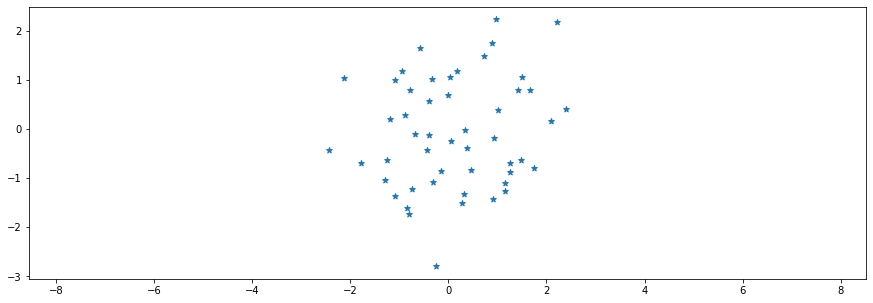

In [4]:
N=50
d=2

np.random.seed(seed)
data=np.random.randn(N,d)
plt.scatter(data[:,0], data[:,1], marker='*', cmap=my_cmap)
plt.axis('equal')
plt.show()

## Step 1: Constructing the adjacency graph
## Step 2: Choosing the weights

Step 1 and 2 of the LE algorithm are in general computed together as they are very related. The graph is not explicitly computed, but we connect vertices via the weight matrix.

In [19]:
t=0.1
k=100

W=np.zeros((N,N))

for i in range(N):
    x_0 = data[i,:]
    
    dist=np.sum((x_0-data)**2,1)
    neigs=dist.argsort()
    
    #Compute Heat Kernel
    w = np.exp(-dist[neigs[1:k+1]]**2/4/t)
    
    #Fill in W just the neighbours of each point
    W[i,neigs[1:k+1]] = w
    
#Symmetric weight matrix
W=(W+W.T)/2

<div class="qst">

* Define the weight matrix in terms of the Heat Kernel.

</div>

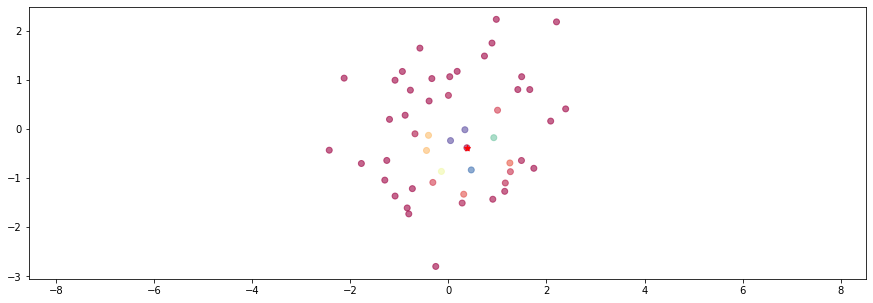

In [20]:
#Plot colored by weight with the last point of the sample as reference.
plt.scatter(data[:,0], data[:,1], marker='o', c=W[-1], cmap=my_cmap, alpha=0.6)
plt.scatter(x_0[0], x_0[1], color='r', marker='*')
plt.axis('equal')
plt.show()

## Step 3: Computing eigenmaps

<div class="qst">

* Define the Laplacian matrix L.

</div>

In [57]:
D = np.diag(np.sum(W, axis=1))
L = D - W

For obtaining the embedding coordinates, we just have to perform the eigenanalysis of L. The coordinates will be defined by the eigenvectors corresponding to the lowest eigenvalues, except for the eigenvalue $0$.

In [58]:
lamb, v = np.linalg.eig(L)
id_lamb = lamb.argsort()

Plotting the eigenvalues can give us interesting information. Here we appreciate that the first eigenvalue is equal to 0, then we have two eigenvalues almost with the same value, and a gap between those and the remaining ones.

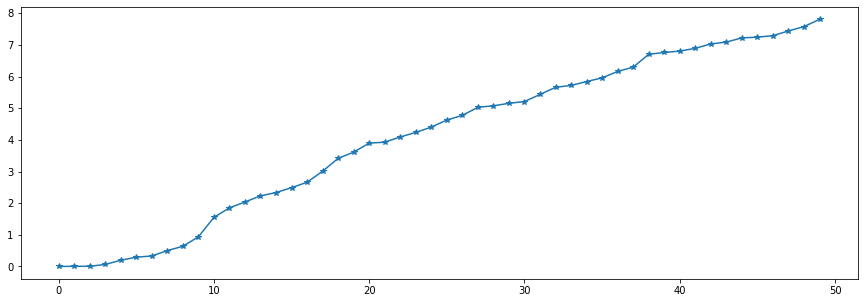

In [59]:
plt.plot(lamb[id_lamb], '*-')
plt.show()

Lastly, we can plot the embedded coordinates.

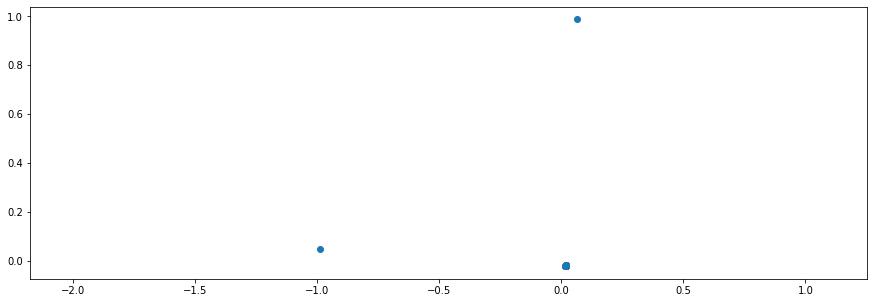

In [60]:
plt.scatter (v[:,id_lamb[1]], v[:,id_lamb[2]])
plt.axis('equal')
plt.show()

## Complete algorithm definition

In [61]:
def LE(data,N,t,k):
    # Weight matrix computation
    W = np.zeros((N,N))
    for i in range(N):
        x_0 = data[i,:]
    
        dist=np.sum((x_0-data)**2,1)
        neigs=dist.argsort()
    
        # Compute Heat Kernel
        w = np.exp(-dist[neigs[1:k+1]]**2/4/t)
        
        # Fill in W just the neighbours of each point
        W[i,neigs[1:k+1]] = w
        
    # Symmetric weight matrix
    W = (W+W.T)/2
    
    #Laplacian matrix
    D = np.diag(np.sum(W, axis=1))
    L = D - W

    #Eigendecomposition
    lamb, v = np.linalg.eig(L)
    id_lamb = lamb.argsort()
    
    return [lamb, v, id_lamb]

## Dataset 2

As a second example, we can use our motivational dataset: the **Swiss Roll**.

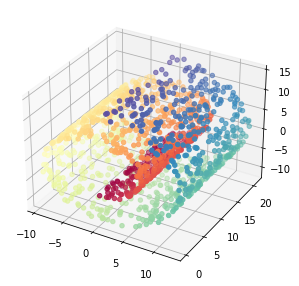

In [62]:
N=1500
SwissRoll, color = make_swiss_roll(n_samples=N)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(SwissRoll[:, 0], SwissRoll[:, 1], SwissRoll[:, 2], c=color, cmap=my_cmap)
plt.show()

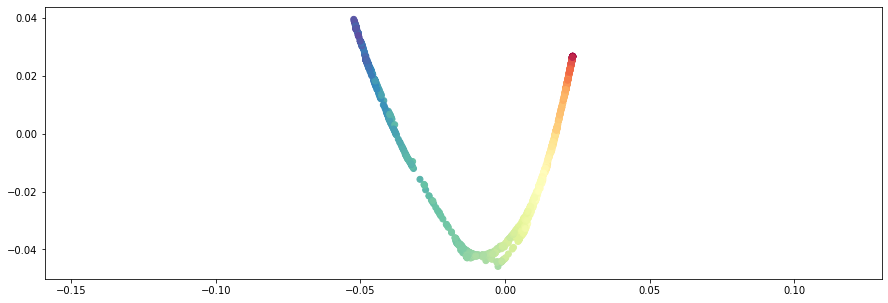

In [72]:
k = 25
t = 2

[lamb, v, id_lamb] = LE(SwissRoll, N, t, k)
plt.scatter(v[:,id_lamb[1]], v[:,id_lamb[2]], c=color, cmap=my_cmap)
plt.axis('equal')
plt.show()

<div class="tqst">

* Call the previous function LE for this dataset.
* Plot the embedding, is it the expected one?
* Change the values of the hyperparameters $t$ and $k$ to see how they affect the result. 

</div>

## Trivial Solution

**Why are we discarding the first eigenvalue and its corresponding eigenvector?**

Let's see how it looks like.

In [69]:
print(v[:,id_lamb[0]])

[-0.02581989 -0.02581989 -0.02581989 ... -0.02581989 -0.02581989
 -0.02581989]


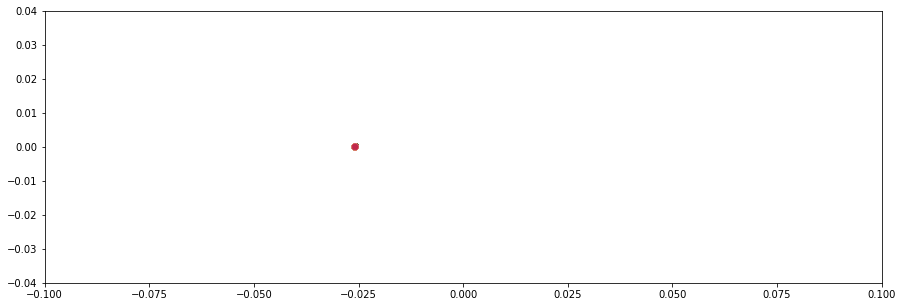

In [70]:
plt.scatter (v[:,id_lamb[0]], np.zeros((N,1)), c=color, cmap=my_cmap)
plt.axis([-0.1,0.1,-0.04,0.04])
plt.show()

<div class="qst">
    
* Which pecularities can you see regarding the eigenvectors and the picture?

</div>

## Swiss Roll Example using Sklearn

Let's compare the result between our implementation and the *scikit-learn* one.

In [73]:
# Using a RBF Kernel for defining the affinity
LE_embedding_rbf = SpectralEmbedding(n_components=2, affinity='rbf', gamma=1e0)

In [94]:
# Using the nearest neighbours approach for defining the affinity
LE_embedding_NN = SpectralEmbedding(n_components=2, affinity='nearest_neighbors',
                                    n_neighbors=800)

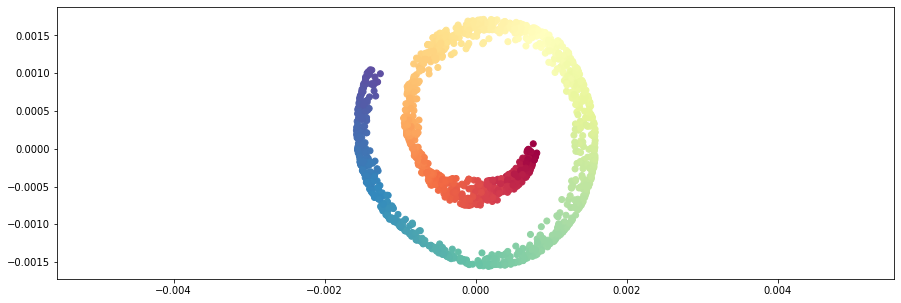

In [95]:
X_r = LE_embedding_NN.fit_transform(SwissRoll)

plt.scatter(X_r[:, 0], X_r[:, 1], c=color, cmap=my_cmap)
plt.axis('equal')
plt.show()

<div class="tqst">

* What differences can you appreciate between both implemented methods?
* And respect to our method (using the Heat Kernel)?
* Change the values of the hyperparameters $gamma$ and $n\_neighbors$ to check how they affect the result.

</div>

# The Heat Flow

This example shows how flows the heat over a material following the Heat Equation.

It has been taken from https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a

2D heat equation solver


MovieWriter ffmpeg unavailable; using Pillow instead.


Done!


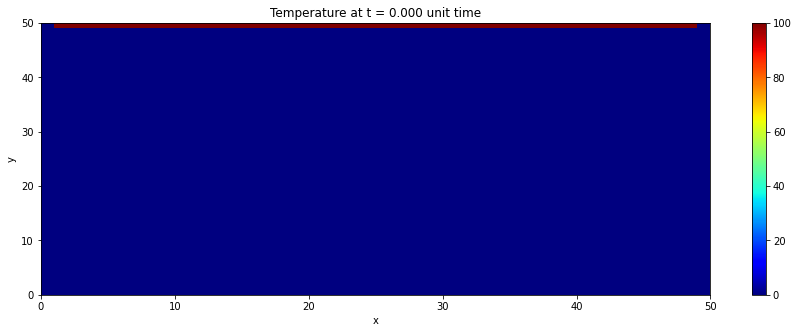

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

print("2D heat equation solver")

plate_length = 50
max_iter_time = 750

alpha = 2
delta_x = 1

delta_t = (delta_x ** 2)/(4 * alpha)
gamma = (alpha * delta_t) / (delta_x ** 2)

# Initialize solution: the grid of u(k, i, j)
u = np.empty((max_iter_time, plate_length, plate_length))

# Initial condition everywhere inside the grid
u_initial = 0

# Boundary conditions
u_top = 100.0
u_left = 0.0
u_bottom = 0.0
u_right = 0.0

# Set the initial condition
u.fill(u_initial)

# Set the boundary conditions
u[:, (plate_length-1):, :] = u_top
u[:, :, :1] = u_left
u[:, :1, 1:] = u_bottom
u[:, :, (plate_length-1):] = u_right

def calculate(u):
    for k in range(0, max_iter_time-1, 1):
        for i in range(1, plate_length-1, delta_x):
            for j in range(1, plate_length-1, delta_x):
                u[k + 1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]

    return u

def plotheatmap(u_k, k):
    # Clear the current plot figure
    plt.clf()

    plt.title(f"Temperature at t = {k*delta_t:.3f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    plt.pcolormesh(u_k, cmap=plt.cm.jet, vmin=0, vmax=100)
    plt.colorbar()

    return plt

# Do the calculation here
u = calculate(u)

def animate(k):
    plotheatmap(u[k], k)

anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=max_iter_time, repeat=False)
anim.save("heat_equation_solution.gif")

print("Done!")